# EXAMPLE NOTEBOOK: Timeseries plot of windspeed at LOCATION[100,100]
### Purpose of this notebook is to demonstrate plotting a timeseries of wind speed at a specific lat-lon location

In [1]:
import os
import iris
import copy
import zarr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import crd_utils as crd

In [4]:
import getpass
account_key = getpass.getpass()

 ························································································


In [5]:
# zarr = '/data/cssp-china/zarr_daily_1851-1859/'
# zarr.storage.ABSStore(container, prefix='', account_name=None, account_key=None, blob_service_kwargs=None)

prefix_read ='zarr_hourly_1851-1859'
zarr_read = zarr.storage.ABSStore('cssp-china', prefix=prefix_read, account_name='awsearth', account_key=account_key, blob_service_kwargs=None)
print(f'/data/cssp-china/{prefix_read}')

/data/cssp-china/zarr_hourly_1851-1859


In [6]:
%%time
ds = xr.open_zarr(zarr_read)
ds

CPU times: user 991 ms, sys: 0 ns, total: 991 ms
Wall time: 2.6 s


<xarray.Dataset>
Dimensions:                  (grid_latitude: 219, grid_latitude_1: 218, grid_longitude: 286, grid_longitude_1: 286, time: 77329)
Coordinates:
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(577,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] ...
  * grid_latitude            (grid_latitude) float32 22.88 22.66 ... -25.08
  * grid_latitude_1          (grid_latitude_1) float32 22.77 ... -24.969997
  * grid_longitude           (grid_longitude) float32 323.48 323.7 ... 386.18002
  * grid_longitude_1         (grid_longitude_1) float32 323.59003 ... 386.29004
    height                   float64 ...
  * time                     (time) datetime64[ns] 1851-01-01 ... 1859-12-29
Data variables:
    surface_air_pressure     (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    x_wind                   (time, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 218, 286), meta=np.ndarray>
    y_wind                   (time, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 218, 286), meta=np.ndarray>

In [7]:
# What is the size in GBs?
ds.nbytes / 1e9

57.945407596

### Using dask_distributed, let's compute the rolling mean

In [8]:
import os
import distributed
import dask
from dask_kubernetes import KubeCluster
from dask import array as da

In [ ]:
cluster = KubeCluster()
# cluster.adapt(minimum=1)
cluster.scale(n=20)
cluster

In [ ]:
client = distributed.Client(cluster)
client

In [9]:
client = distributed.Client('tcp://10.244.0.246:41175')
client


Client Scheduler: tcp://10.244.0.246:41175 Dashboard: /user/kaedonkers/proxy/8787/status,Cluster Workers: 20 Cores: 20 Memory: 160.00 GB


## Calculate wind speed from `x/y_wind`

In [15]:
%%time
x_100 = ds.x_wind[:, 100, 100]
y_100 = ds.y_wind[:, 100, 100]
wind_speed_100 = (x_100**2 + y_100**2)**0.5
wind_speed_100.rename('wind_speed_100')
wind_speed_100

CPU times: user 71.2 ms, sys: 482 µs, total: 71.7 ms
Wall time: 157 ms


<xarray.DataArray (time: 77329)>
dask.array<pow, shape=(77329,), dtype=float32, chunksize=(200,), chunktype=numpy.ndarray>
Coordinates:
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(577,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] 1849-12-01
    grid_latitude_1          float32 0.77000046
    grid_longitude_1         float32 345.59003
    height                   float64 10.0
  * time                     (time) datetime64[ns] 1851-01-01 ... 1859-12-29

In [14]:
%%time
x_wind = ds.x_wind
y_wind = ds.y_wind
wind_speed = (x_wind**2 + y_wind**2)**0.5
wind_speed.rename('wind_speed')
wind_speed[:, 100, 100]

CPU times: user 68.9 ms, sys: 0 ns, total: 68.9 ms
Wall time: 146 ms


<xarray.DataArray (time: 77329)>
dask.array<getitem, shape=(77329,), dtype=float32, chunksize=(200,), chunktype=numpy.ndarray>
Coordinates:
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(577,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] 1849-12-01
    grid_latitude_1          float32 0.77000046
    grid_longitude_1         float32 345.59003
    height                   float64 10.0
  * time                     (time) datetime64[ns] 1851-01-01 ... 1859-12-29

## Plot timeseries for location [100,100]

CPU times: user 657 ms, sys: 28.4 ms, total: 685 ms
Wall time: 41.3 s


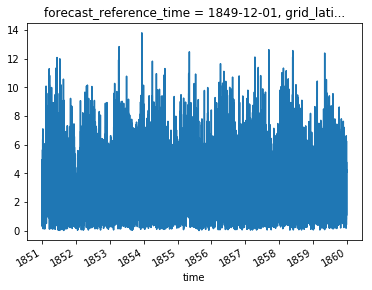

In [16]:
%%time
wind_speed_100.plot()

CPU times: user 517 ms, sys: 23.9 ms, total: 541 ms
Wall time: 40.1 s


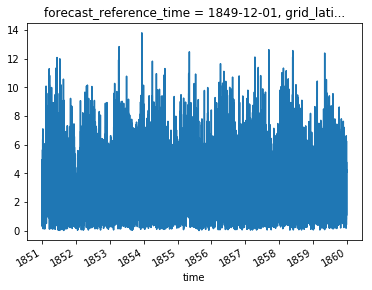

In [17]:
%%time
wind_speed_100.plot()